In [8]:
import cv2 as cv
import numpy as np
import operator
from imutils import contours
import imutils

from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras


In [9]:
#sudokusolver

def findNextCellToFill(grid, i, j):
        for x in range(i,9):
                for y in range(j,9):
                        if grid[x][y] == 0:
                                return x,y
        for x in range(0,9):
                for y in range(0,9):
                        if grid[x][y] == 0:
                                return x,y
        return -1,-1

def isValid(grid, i, j, e):
        rowOk = all([e != grid[i][x] for x in range(9)])
        if rowOk:
                columnOk = all([e != grid[x][j] for x in range(9)])
                if columnOk:
                        # finding the top left x,y co-ordinates of the section containing the i,j cell
                        secTopX, secTopY = 3 *(i//3), 3 *(j//3) #floored quotient should be used here.
                        for x in range(secTopX, secTopX+3):
                                for y in range(secTopY, secTopY+3):
                                        if grid[x][y] == e:
                                                return False
                        return True
        return False

def solveSudoku(grid, i=0, j=0):
        i,j = findNextCellToFill(grid, i, j)
        if i == -1:
                return True
        for e in range(1,10):
                if isValid(grid,i,j,e):
                        grid[i][j] = e
                        if solveSudoku(grid, i, j):
                                return True
                        # Undo the current cell for backtracking
                        grid[i][j] = 0
        return False

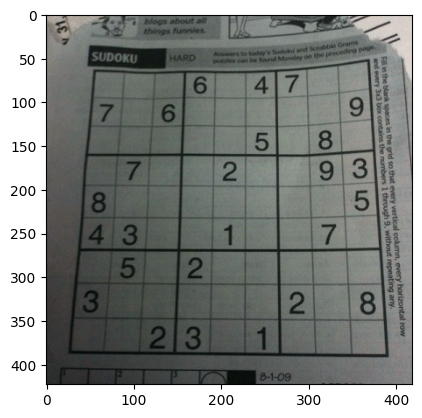

In [65]:
margin = 10
case = 28 + 2*margin
perspective_size = 9*case
flag = 0
ans = 0
image = cv.imread('/content/drive/MyDrive/Colab Notebooks/Sudoku/input.png')
p_image = image.copy()
plt.imshow(p_image)

In [66]:
#Process the image to find contour
gray=cv.cvtColor(image, cv.COLOR_BGR2GRAY)
gray=cv.GaussianBlur(gray, (5, 5), 0)
thresh=cv.adaptiveThreshold(gray, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 9, 2)

#Get all the contours in the image
contours_, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
contour = None
maxArea = 0

#Find the largest contour(Sudoku Grid)
for c in contours_:
    area = cv.contourArea(c)

    if area > 25000:
        peri = cv.arcLength(c, True)
        polygon = cv.approxPolyDP(c, 0.01*peri, True)

        if area>maxArea and len(polygon)==4:
            contour = polygon
            maxArea = area


print(contour , maxArea)

[[[369  51]]

 [[ 55  63]]

 [[ 25 387]]

 [[390 392]]] 111345.0


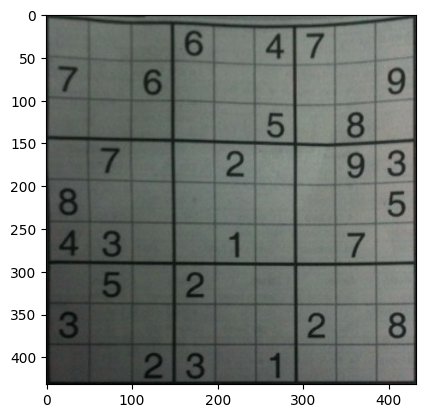

In [67]:
#Draw the contour and extract Sudoku Grid
if contour is not None:
    cv.drawContours(image, [contour], 0, (0, 255, 0), 2)
    points = np.vstack(contour).squeeze()
    points = sorted(points, key=operator.itemgetter(1))

    if points[0][0]<points[1][0]:
        if points[3][0]<points[2][0]:
            pts1 = np.float32([points[0], points[1], points[3], points[2]])
        else:
            pts1 = np.float32([points[0], points[1], points[2], points[3]])
    else:
        if points[3][0]<points[2][0]:
            pts1 = np.float32([points[1], points[0], points[3], points[2]])
        else:
            pts1 = np.float32([points[1], points[0], points[2], points[3]])

    pts2 = np.float32([[0, 0], [perspective_size, 0], [0, perspective_size], [perspective_size, perspective_size]])
    matrix = cv.getPerspectiveTransform(pts1, pts2)
    perspective_image =cv.warpPerspective(p_image, matrix, (perspective_size, perspective_size))
    result = perspective_image.copy()

    plt.imshow(result)

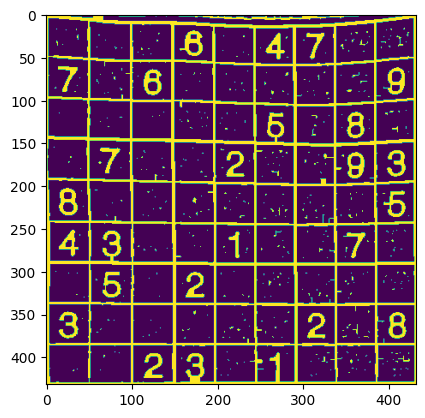

In [68]:
#Process the extracted Sudoku Grid
# pers_image = cv.cvtColor(perspective_image, cv.COLOR_BGR2RGB)
pers_image = cv.cvtColor(perspective_image, cv.COLOR_BGR2GRAY)
pers_image = cv.GaussianBlur(pers_image, (5, 5), 0)
pers_image = cv.adaptiveThreshold(pers_image, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 9, 2)
vertical_kernel = cv.getStructuringElement(cv.MORPH_RECT,(5,5))
pers_image = cv.morphologyEx(pers_image, cv.MORPH_CLOSE, vertical_kernel)
lines = cv.HoughLinesP(pers_image, 1, np.pi/180, 120, minLineLength=40, maxLineGap=10)
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv.line(perspective_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.imshow(pers_image)

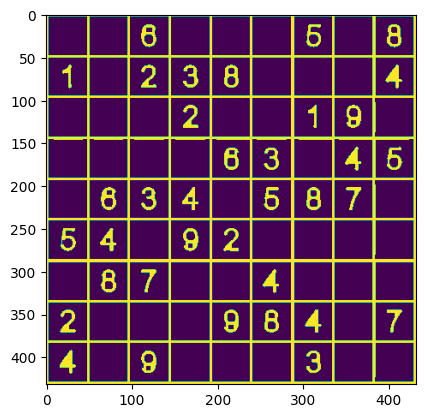

In [63]:
#Invert the grid for digit recognition

invert = 255 - pers_image
invert_image = invert.copy()
invert_image = invert_image /255
plt.imshow(pers_image)




In [53]:
# loading trained model

new_model = tf.keras.models.load_model('/content/drive/MyDrive/Trained Models/Dizit_rec.h5')

In [49]:
#Arranging predicted digit nested list
def display_predList(predList):
    predicted_digits = []
    for i in range(len(predList)):
        for j in range(len(predList)):
            predicted_digits.append(predList[j][i])

    return predicted_digits

In [54]:
i = 0

#Check if the answer has been already predicted or not
#If not predict the answer
#Else only get the cell regions
if flag != 1:
    predicted_digits = []
    pixels_sum = []

#To get individual cells
for y in range(9):
    predicted_line = []
    for x in range(9):
                y2min = y*case+margin
                y2max = (y+1)*case-margin
                x2min = x*case+margin
                x2max = (x+1)*case-margin

                #Obtained Cell
                image = invert_image[y2min:y2max, x2min:x2max]

                #Process the cell to feed it into model
                img = cv.resize(image,(28,28))
                img = img.reshape((1,28,28,1))

                #Get sum of all the pixels in the cell
                #If sum value is large it means the cell is blank
                pixel_sum = np.sum(img)
                pixels_sum.append(pixel_sum)

                #Predict the digit in the cell
                pred = new_model.predict(img)
                predicted_digit = pred.argmax()

                #For blank cells set predicted digit to 0
                if pixel_sum > 775.0:
                    predicted_digit = 0

                predicted_line.append(predicted_digit)

                #If we already have predicted result, display it on window


                i = i + 1

    #Get predicted digit list
    if flag != 1:
        predicted_digits.append(predicted_line)

print(len(predicted_digits))
print(predicted_digits)

1/1 [==============================] - 0s 19ms/step
9
[[0, 0, 6, 0, 0, 0, 6, 0, 6], [0, 0, 2, 6, 6, 0, 0, 0, 9], [0, 0, 0, 2, 0, 0, 0, 9, 0], [0, 0, 0, 0, 6, 6, 0, 2, 5], [0, 6, 6, 2, 0, 6, 6, 7, 0], [6, 4, 0, 0, 2, 0, 0, 0, 0], [0, 6, 7, 0, 0, 9, 0, 0, 0], [2, 0, 0, 0, 9, 8, 4, 0, 7], [4, 0, 9, 0, 0, 0, 8, 0, 0]]


In [ ]:
if flag == 1:
    ans = 1
    x_pos = int((x2min + x2max)/ 2)+10
    y_pos = int((y2min + y2max)/ 2)-5
    image = cv.putText(result, str(pred_digits[i]), (y_pos, x_pos), cv.FONT_HERSHEY_SIMPLEX,
    1, (255, 0, 0), 2, cv.LINE_AA)

In [33]:
ans = solveSudoku(predicted_digits)

if ans==True:
    flag = 1
    pred_digits = display_predList(predicted_digits)

    #Display the final result
    if ans == 1:
        cv.imshow("Result", result)
        frame = cv.warpPerspective(result, matrix, (perspective_size, perspective_size), flags=cv.WARP_INVERSE_MAP)

# cv.imshow("frame", frame)
# cv.imshow('P-Window', p_window)
# cv.imshow('Invert', invert)



plt.imshow("frame", frame)

IndexError: ignored